In [1]:
!pip install numpy pandas matplotlib seaborn plotly requests tqdm opencv-python pillow wandb -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://download.pytorch.org/whl/cu113


In [3]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


In [5]:
from torchvision import transforms


train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [6]:
dataset_dir = 'rsdata'

In [7]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')

训练集路径 rsdata/train
测试集路径 rsdata/val


In [9]:
!find . -iname '.ipynb_checkpoints'

./.ipynb_checkpoints
./rsdata/.ipynb_checkpoints
./rsdata/val/.ipynb_checkpoints
./rsdata/train/.ipynb_checkpoints


In [10]:
'.ipynb_checkpoints' in os.listdir('rsdata')

True

In [11]:
!for i in `find . -iname '.ipynb_checkpoints'`; do rm -rf $i;done

In [12]:
!find . -iname '.ipynb_checkpoints'

In [13]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(train_path, train_transform)

test_dataset = datasets.ImageFolder(test_path, test_transform)

In [14]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 320
类别个数 2
各类别名称 ['0', '1']


In [15]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)

In [16]:
class_names

['0', '1']

In [17]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'0': 0, '1': 1}

In [18]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [19]:
idx_to_labels

{0: '0', 1: '1'}

In [20]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

In [21]:
from torch.utils.data import DataLoader

In [22]:
BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

In [23]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [24]:
images.shape

torch.Size([32, 3, 224, 224])

In [25]:
labels

tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1])

In [26]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [27]:
images[5].shape

(3, 224, 224)

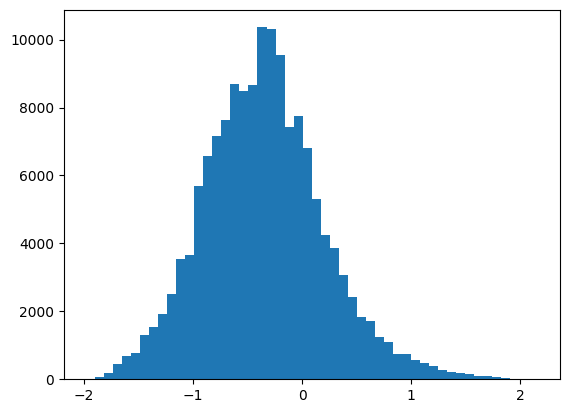

In [28]:
plt.hist(images[5].flatten(), bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:0')

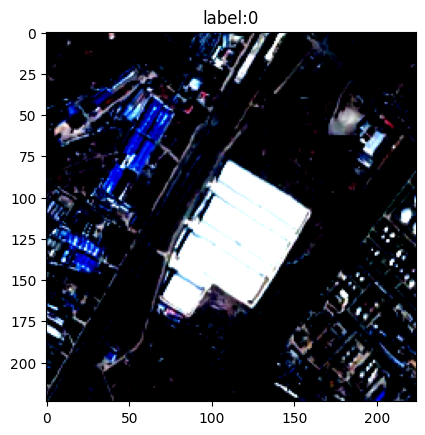

In [29]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [30]:
label = labels[idx].item()

In [31]:
label

0

In [32]:
pred_classname = idx_to_labels[label]

In [33]:
pred_classname

'0'

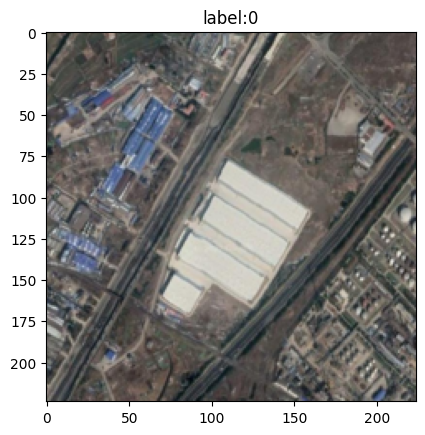

In [34]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()

In [35]:
from torchvision import models
import torch.optim as optim

In [37]:
model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

model.fc = nn.Linear(model.fc.in_features, n_class)

optimizer = optim.Adam(model.parameters())

In [38]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 20

In [39]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [40]:
# 输入模型，执行前向预测
outputs = model(images)

In [41]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([32, 2])

In [42]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)

In [43]:
# 反向传播“三部曲”
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [44]:
# 获得当前 batch 所有图像的预测类别
_, preds = torch.max(outputs, 1)

In [45]:
preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
labels

tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1])

In [47]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获取训练集的一个 batch，包含数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)           # 前向预测，获得当前 batch 的预测结果
        loss = criterion(outputs, labels) # 比较预测结果和标注，计算当前 batch 的交叉熵损失函数
        
        optimizer.zero_grad()
        loss.backward()                   # 损失函数对神经网络权重反向传播求梯度
        optimizer.step()                  # 优化更新神经网络权重

100%|██████████| 20/20 [21:54<00:00, 65.71s/it] 


In [48]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader): # 获取测试集的一个 batch，包含数据和标注
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)              # 前向预测，获得当前 batch 的预测置信度
        _, preds = torch.max(outputs, 1)     # 获得最大置信度对应的类别，作为预测结果
        total += labels.size(0)
        correct += (preds == labels).sum()   # 预测正确样本个数

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|██████████| 3/3 [00:19<00:00,  6.54s/it]

测试集上的准确率为 60.000 %


In [50]:
torch.save(model, 'rssmaple_pytorch_C1.pth')

In [51]:
!pip install grad-cam torchcam

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 258.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 74.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 261.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 81.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 117.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 201.9 MB/s eta 0:00:00a 0:00:01
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 263.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.

In [52]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1115, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1115 (delta 4), reused 11 (delta 3), pack-reused 1097
Receiving objects: 100% (1115/1115), 110.17 MiB | 7.32 MiB/s, done.
Resolving deltas: 100% (613/613), done.


In [53]:
import os

In [54]:
# 存放测试图片
os.mkdir('test_img')

# 存放结果文件
os.mkdir('output')

# 存放模型权重文件
os.mkdir('checkpoint')

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from PIL import Image

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


In [120]:
model = torch.load('checkpoint/rssmaple_pytorch_C1.pth')
model = model.eval().to(device)

In [121]:
from torchcam.methods import GradCAMpp
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

cam_extractor = GradCAMpp(model)

In [122]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [123]:
img_path = 'test_img/6.jpg'

In [124]:
img_pil = Image.open(img_path)
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理

In [125]:
pred_logits = model(input_tensor)
pred_id = torch.topk(pred_logits, 1)[1].detach().cpu().numpy().squeeze().item()

In [126]:
pred_id

1

In [127]:
activation_map = cam_extractor(pred_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()

In [128]:
activation_map.shape

(7, 7)

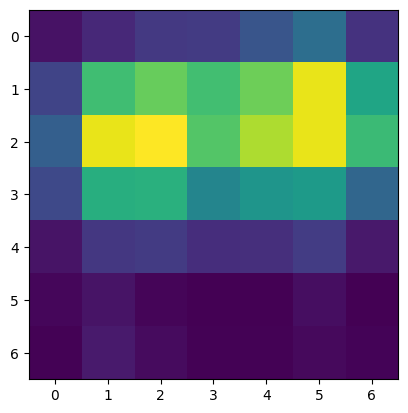

In [129]:
plt.imshow(activation_map)
plt.show()

In [130]:
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

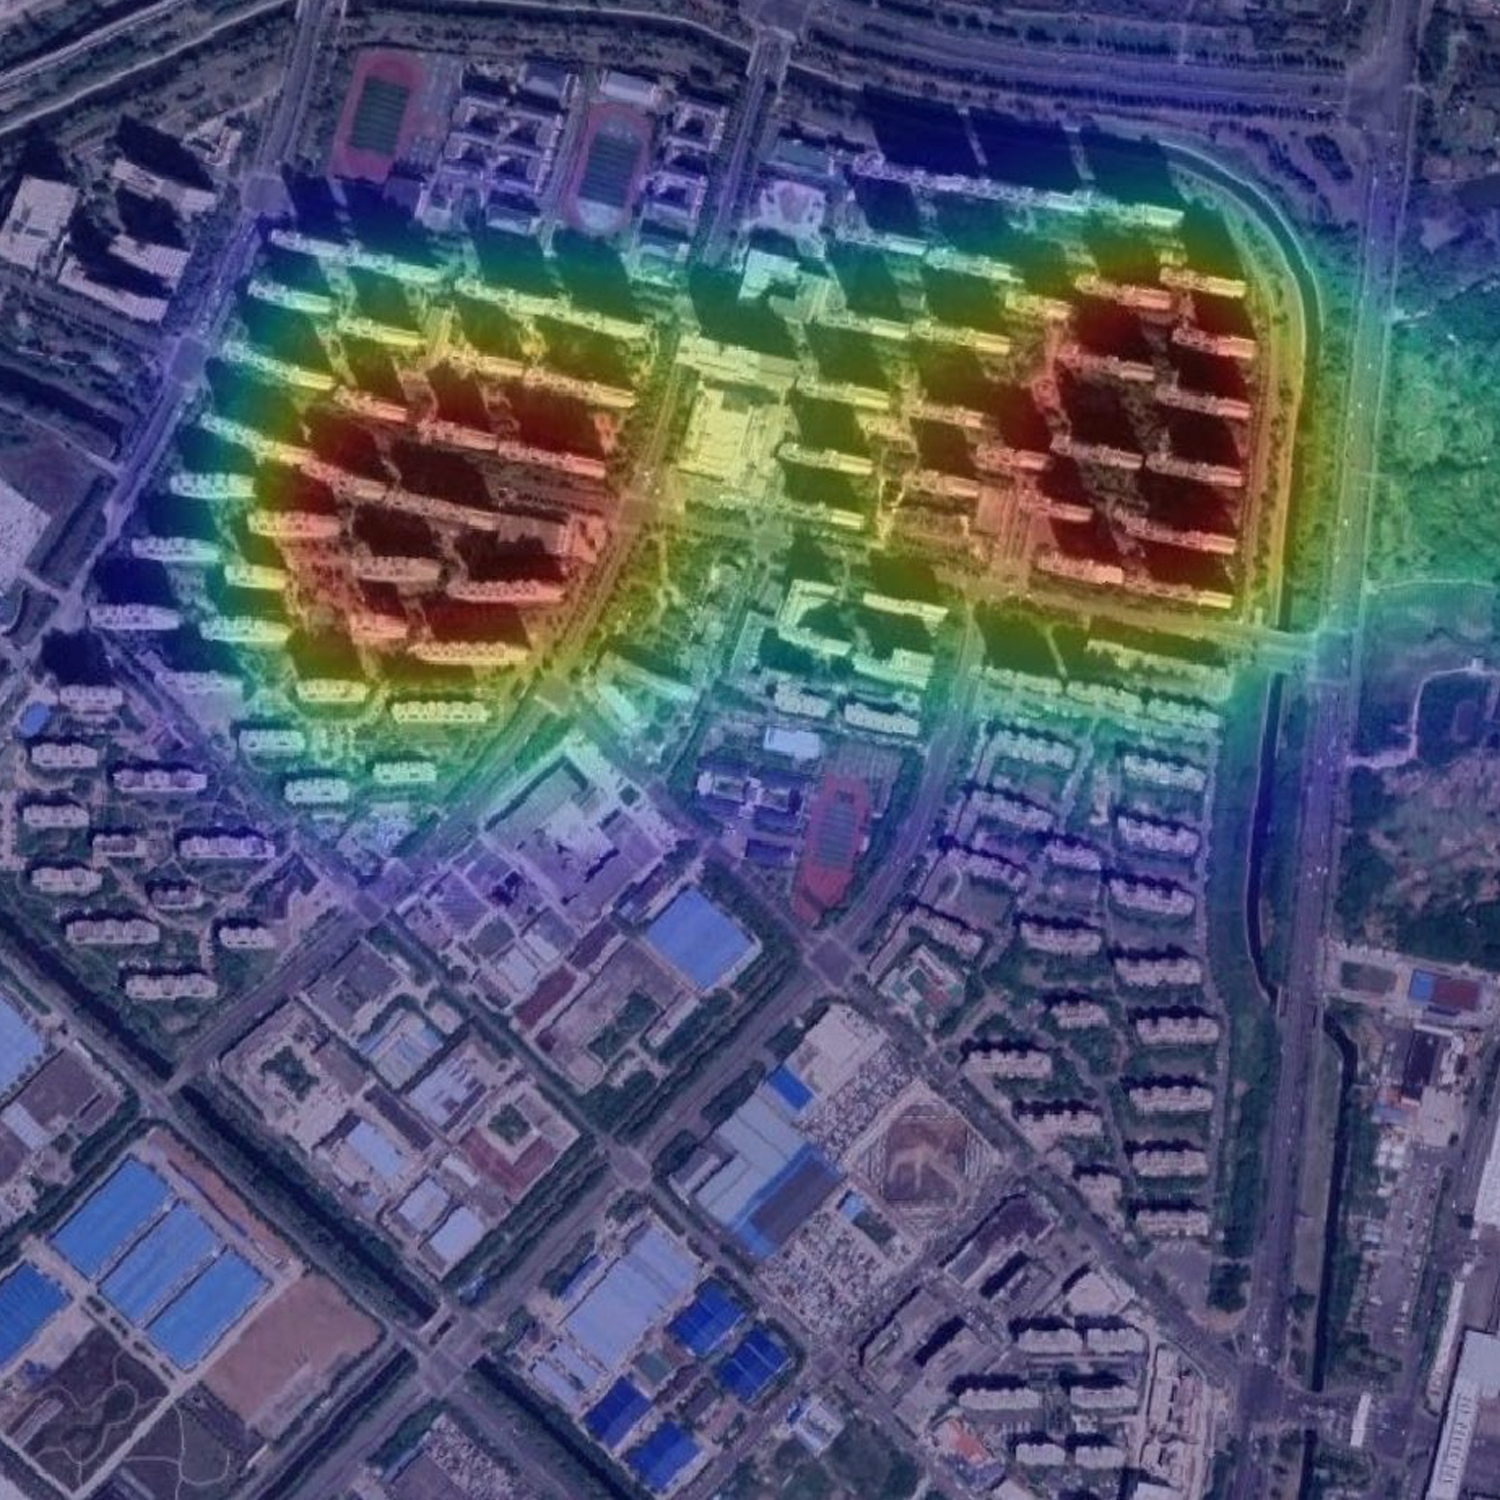

In [131]:
result

In [132]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
labels_to_idx = np.load('labels_to_idx.npy', allow_pickle=True).item()

In [133]:
idx_to_labels

{0: '0', 1: '1'}

In [134]:
labels_to_idx

{'0': 0, '1': 1}

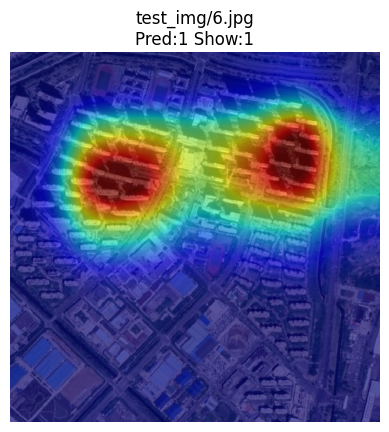

In [136]:
img_path = 'test_img/6.jpg'

# 可视化热力图的类别，如果不指定，则为置信度最高的预测类别
show_class = '1'

# 前向预测
img_pil = Image.open(img_path)
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
pred_logits = model(input_tensor)
pred_id = torch.topk(pred_logits, 1)[1].detach().cpu().numpy().squeeze().item()

if show_class:
    class_id = labels_to_idx[show_class]
    show_id = class_id
else:
    show_id = pred_id

# 获取热力图
activation_map = cam_extractor(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.4)
plt.imshow(result)
plt.axis('off')

plt.title('{}\nPred:{} Show:{}'.format(img_path, idx_to_labels[pred_id], show_class))
plt.show()

In [137]:
!pip install numpy pandas matplotlib requests tqdm opencv-python pillow -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [138]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.models import resnet50

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


In [139]:
model = torch.load('checkpoint/rssmaple_pytorch_C1.pth')
model = model.eval().to(device)

In [140]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(512),
                                     # transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [141]:
img_path = 'test_img/6.jpg'

In [142]:
img_pil = Image.open(img_path)

In [143]:
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理

In [144]:
input_tensor.shape

torch.Size([1, 3, 512, 512])

In [155]:
# 如果 targets 为 None，则默认为最高置信度类别
targets = [ClassifierOutputTarget(1)]

In [156]:
model.layer4[-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [157]:
model.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [158]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, XGradCAM, AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM

In [159]:
# Grad-CAM
from pytorch_grad_cam import GradCAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

In [160]:
cam_map = cam(input_tensor=input_tensor, targets=targets)[0] # 不加平滑
# cam_map = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)[0] # 加平滑

In [161]:
cam_map.shape

(512, 512)

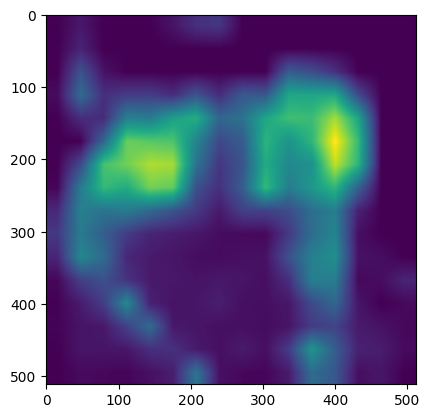

In [162]:
plt.imshow(cam_map)
plt.show()

In [163]:
import torchcam
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(cam_map), alpha=0.6) # alpha越小，原图越淡

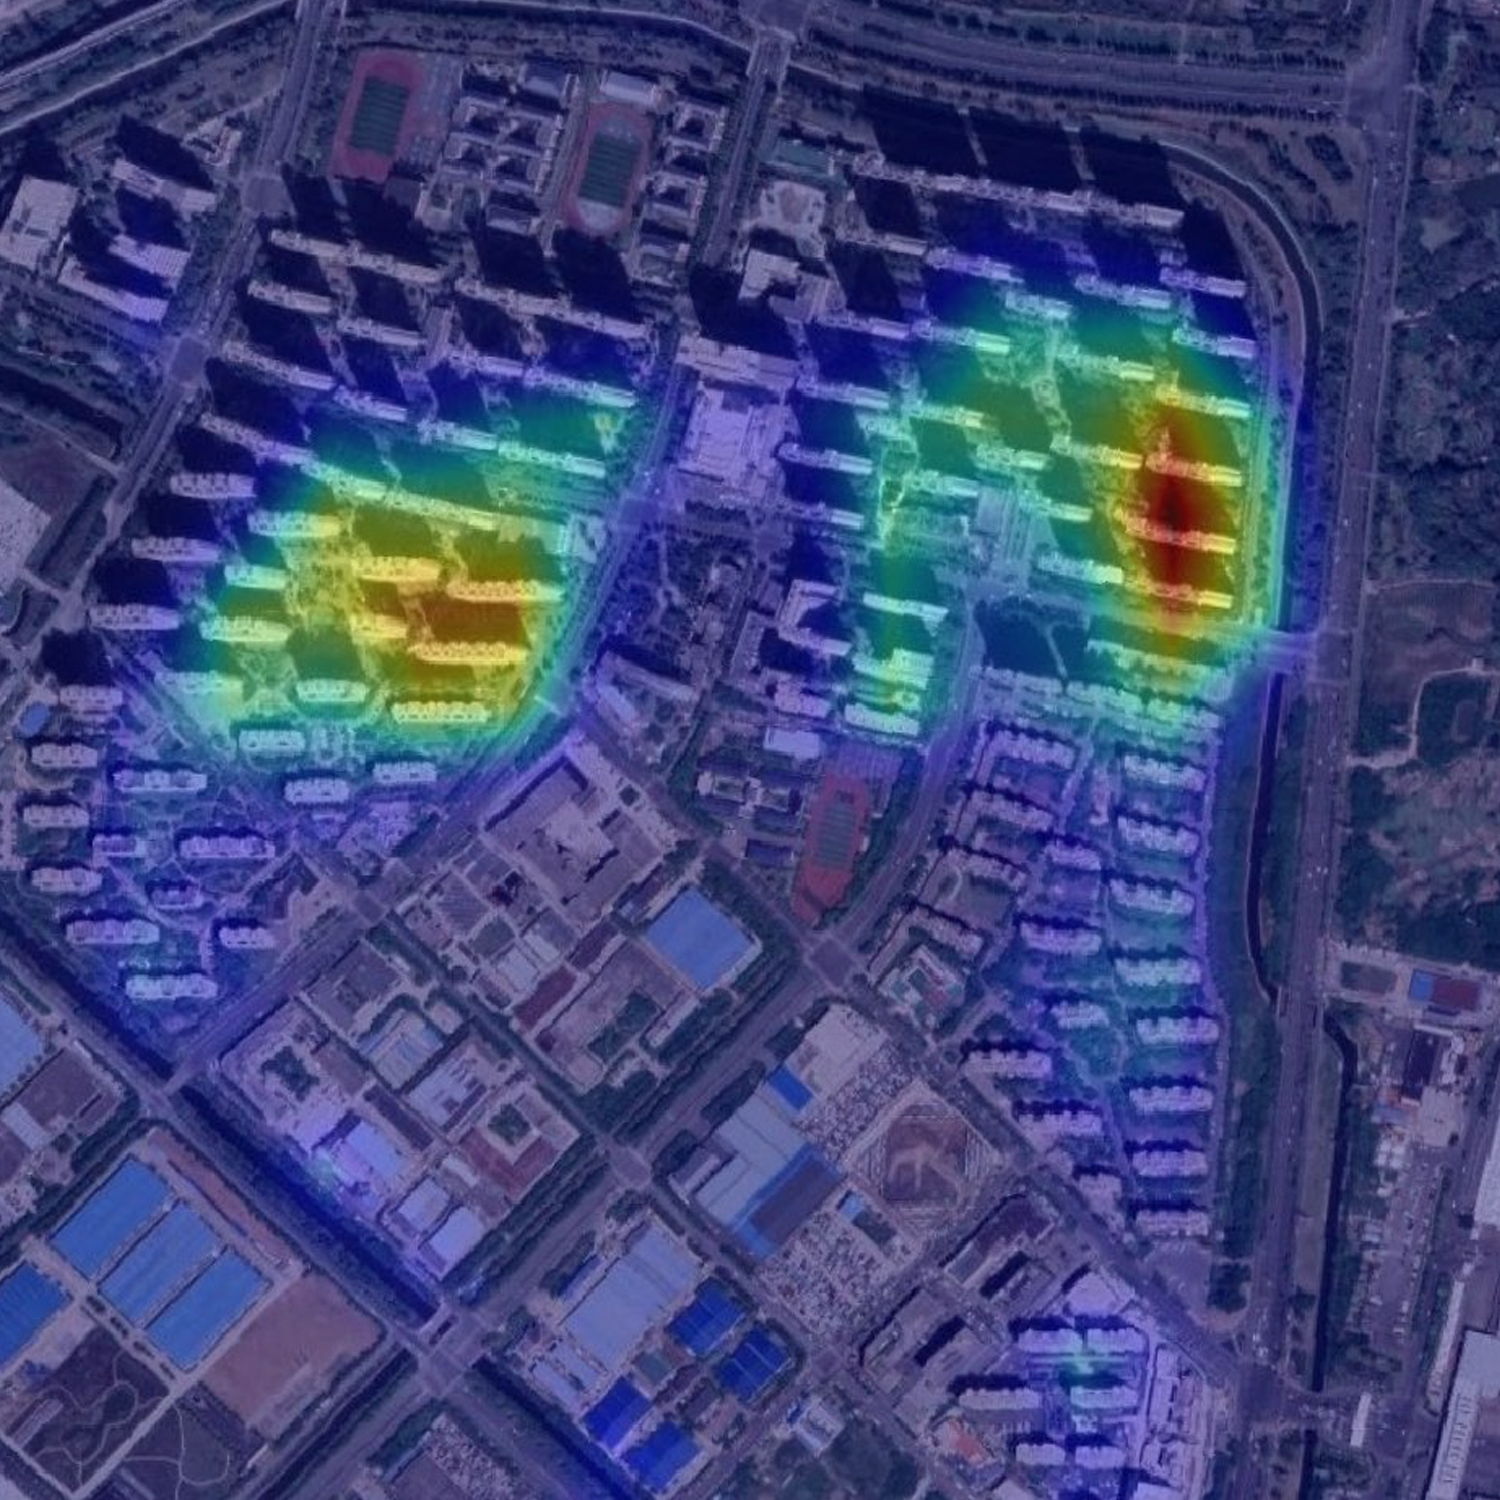

In [164]:
result